In [ ]:
#Step : 1
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Step 2 :
import tensorflow_datasets as tfds

#Load the dataset
dataset, info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)

#Extract the data
full_dataset = dataset['train']

# from the above ->  dataset	A dictionary of dataset splits
# dataset["train"]	The only available split for Cats vs Dogs, containing all images

print("Dataset loaded Successfully")
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.O75LZY_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset loaded Successfully
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
   

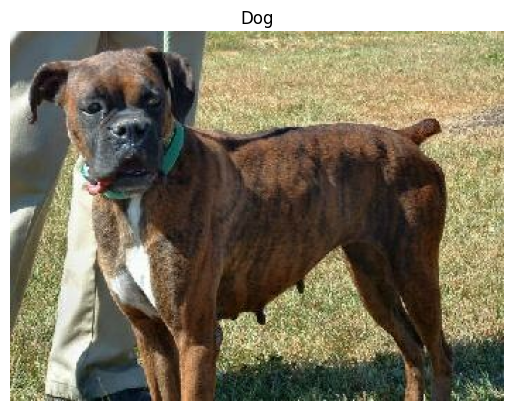

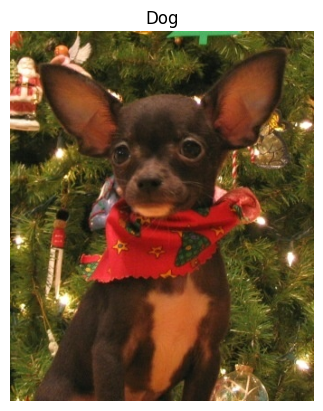

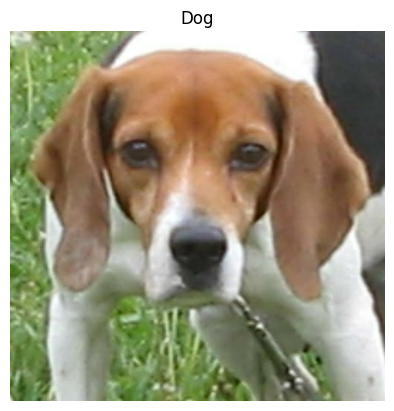

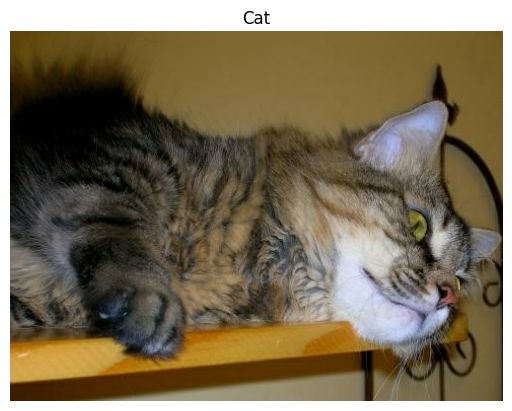

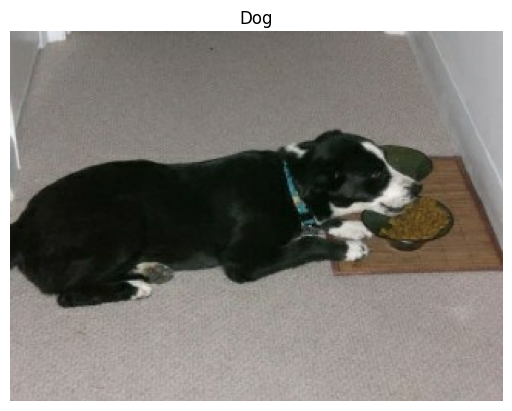

In [ ]:
# Step : 3
import matplotlib.pyplot as plt

#Function to show one image
def show_image(image, label):

    plt.imshow(image)
    plt.title("Cat" if label==0 else "Dog")
    plt.axis("off")
    plt.show()



for image, label in full_dataset.take(5):
  show_image(image.numpy(), label.numpy())

### Step 3 — Visualizing Images
- Helps understand the dataset before training.
- Confirms that images load correctly and labels are accurate.
- Converts TensorFlow tensors to NumPy arrays for display.


In [ ]:
IMG_SIZE = 150      # We can increase later for accuracy

def preprocess(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0
  return image, label

#Apply preprocessing to the entire dataset
processed_dataset = full_dataset.map(preprocess)      # .map() applies the preprocess() function to every image-label pair

# Shuffle and Split the Dataset
dataset_size= info.splits['train'].num_examples
train_size= int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = processed_dataset.take(train_size)    # take(train_size) → pick the first 80% of cards (training)
val_dataset = processed_dataset.skip(train_size)     # skip(train_size) → skip those cards and use the rest (validation)


#Shuffle and batch the dataset
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)




Why this step is needed:

Images in the dataset come in different sizes → CNNs require fixed-size images

Pixel values range from 0–255 → neural networks learn better when normalized (0–1)

The dataset comes as one large split, so we manually split it into:

Training set (80%)

Validation set (20%)

Data must be batched and shuffled for efficient and stable training

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])


In [ ]:
model = Sequential([
    data_augmentation,  # NEW

    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dropout(0.5),  # NEW

    Dense(128, activation='relu'),
    Dropout(0.3),  # NEW

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Why this step is important:

In this step, we create the actual neural network that will learn to classify images as cat or dog.
A CNN is specially designed for image tasks because it can automatically learn:

edges

shapes

textures

high-level features (ears, fur patterns, face structure)

This makes CNNs extremely powerful for computer vision.

⭐ Key Components of the CNN
1. Convolution Layers (Conv2D)

These layers extract features from the image.

The model learns filters that detect patterns like edges, corners, and textures.

More filters = deeper and richer feature learning.

2. MaxPooling Layers

Reduce the size of the image representation.

Helps the model train faster.

Prevents overfitting.

Keeps only the most important features.

3. Flatten Layer

Converts the 2D feature maps into a 1D vector.

Required before feeding data into dense (fully connected) layers.

4. Dense Layers (Fully Connected Layers)

Learn high-level combinations of features detected by previous layers.

Example: “pointy ears + whiskers → likely a cat”.

5. Output Layer (Sigmoid activation)

Outputs a value between 0 and 1.

Used for binary classification:

0 → Cat

1 → Dog

🎯 Outcome of this step

By the end of Step 5:

The CNN architecture is fully defined.

The model knows how it will process images.

You can now compile and train the model in the next step.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.5536 - loss: 0.6865 - val_accuracy: 0.6796 - val_loss: 0.6014
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.6896 - loss: 0.5965 - val_accuracy: 0.7445 - val_loss: 0.5239
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 82ms/step - accuracy: 0.7234 - loss: 0.5442 - val_accuracy: 0.7842 - val_loss: 0.4633
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.7534 - loss: 0.5098 - val_accuracy: 0.8053 - val_loss: 0.4400
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.7762 - loss: 0.4794 - val_accuracy: 0.8253 - val_loss: 0.4024
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.7862 - loss: 0.4615 - val_accuracy: 0.8018 - val_loss: 0.4284
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.7919 - loss: 0.4482 - val_accuracy: 0.8384 - val_loss: 0.3734
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.8080 - loss: 0.4272 - 

### Step 6 — Compile the CNN Model

- **optimizer='adam'**
  Adam optimizer adjusts learning rates automatically, making training fast and stable.

- **loss='binary_crossentropy'**
  Used for binary classification tasks (cat vs dog).
  Measures the difference between predicted and actual labels.

- **metrics=['accuracy']**
  Tracks how many predictions were correct during training.


WHY EPOCHS = 10?

CNN needs more cycles than MNIST because images are larger.

10 epochs is enough to see improvement.

We will adjust based on the performance graph later

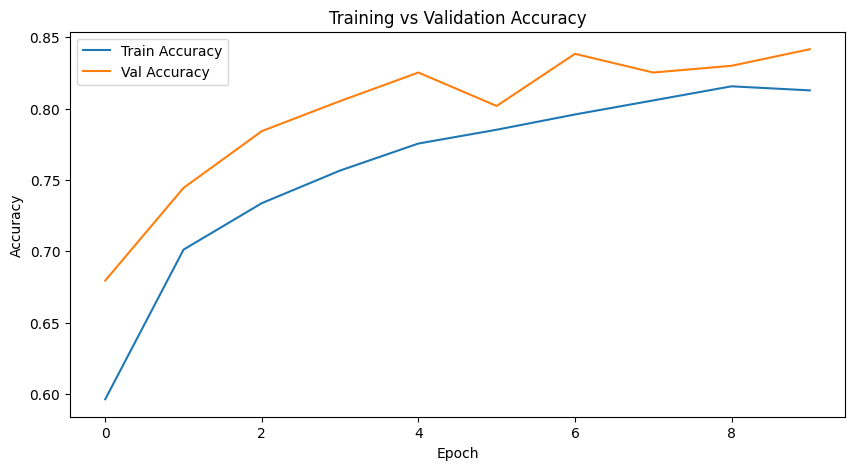

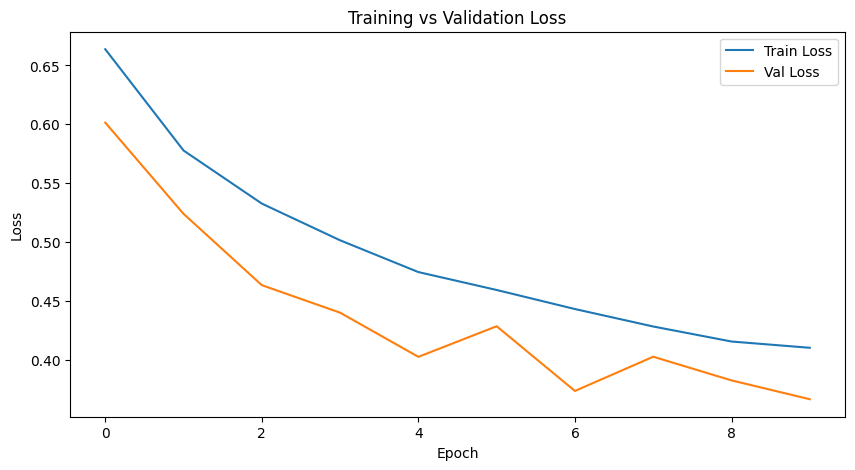

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.8353 - loss: 0.3782
Final Validation Accuracy: 0.8416075706481934
Final Validation Loss: 0.36641064286231995


In [ ]:
# Evaluation and Visualization

import matplotlib.pyplot as plt

# 1️⃣ Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2️⃣ Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3️⃣ Final Evaluation on Validation Data
val_loss, val_acc = model.evaluate(val_dataset)
print("Final Validation Accuracy:", val_acc)
print("Final Validation Loss:", val_loss)


### ✅ Step 8: Visualizing Training Curves

We plot training and validation accuracy/loss to understand how well our CNN is learning.

**What we expect:**
- Training accuracy should increase with epochs.
- Validation accuracy should also increase but not drop suddenly.
- Loss should decrease for both training and validation.
- Validation loss should not be much higher than training loss.

**From our plots:**
- Training and validation accuracy both improved steadily.
- Validation accuracy is higher than training accuracy → great generalization.
- Training and validation loss both decreased smoothly.
- No signs of overfitting.




In [ ]:
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for filename in uploaded.keys():
    print("Uploaded file:", filename)


Saving cat.jpg to cat.jpg
Uploaded file: cat.jpg


In [ ]:
def prepare_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [ ]:
img = prepare_image(list(uploaded.keys())[0])

prediction = model.predict(img)

if prediction[0] > 0.5:
    print("Prediction: 🐶 Dog")
else:
    print("Prediction: 🐱 Cat")

print("Prediction Score:", float(prediction[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Prediction: 🐶 Dog
Prediction Score: 0.5927751064300537


/tmp/ipython-input-3694680092.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Prediction Score:", float(prediction[0]))
